# 📊 統合ダッシュボード - コンビニエンスストア経営支援

## 目的
**Stage 1〜5の分析結果を統合し、経営判断に必要な情報を一目で把握する**

このノートブックは、フランチャイジーが日次・週次で確認すべき主要指標を
ダッシュボード形式で表示します。

### ダッシュボードの構成
1. **サマリー（KPI）**
   - 売上・客数・客単価の推移
   - 前日比・前週比・前月比
   - 目標達成率

2. **ABC分析サマリー**
   - A商品の欠品リスク
   - C商品の過剰在庫アラート
   - 死に筋商品の特定

3. **発注推奨**
   - 主要商品の推奨発注量
   - 曜日別の調整係数
   - 発注アラート（欠品リスク商品）

4. **外部要因分析**
   - 明日の天気と売上予測
   - イベント影響
   - 季節性トレンド

5. **アクションリスト**
   - 今日やるべきこと
   - 注意すべき商品
   - 改善提案

### 業務的な使い方
- **朝一番**: このダッシュボードを開いて、今日の状況を把握
- **発注前**: 推奨発注量と天気予報を確認
- **週次会議**: 過去1週間のトレンドを確認
- **月次報告**: 本部への報告資料として活用

---

## 📦 1. 環境準備

In [1]:
# 日本語フォント設定（正しい順序）
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
from datetime import datetime, timedelta
from pathlib import Path

# ========================================
# ステップ1: matplotlibの基本設定（最初）
# ========================================
matplotlib.rcParams['axes.unicode_minus'] = False

# ========================================
# ステップ2: 日本語フォントの検出と設定
# ========================================
chosen_font = None

# japanize_matplotlibを試す
try:
    import japanize_matplotlib
    chosen_font = "IPAexGothic"
    print("✅ japanize_matplotlib 使用")
except ImportError:
    # 手動でフォントを検索
    candidates = ["IPAexGothic", "IPAPGothic", "Noto Sans CJK JP", "Noto Sans JP",
                  "Hiragino Sans", "Hiragino Kaku Gothic ProN", "Meiryo", "MS Gothic"]
    avail = {f.name: f.fname for f in font_manager.fontManager.ttflist}

    for font_name in candidates:
        if font_name in avail or any(font_name.lower() in nm.lower() for nm in avail):
            chosen_font = font_name
            break

    if chosen_font:
        print(f"✅ 日本語フォント検出: {chosen_font}")
    else:
        print("⚠️ 日本語フォント未検出 - DejaVu Sans使用")

# フォントファミリーを設定
if chosen_font:
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = [chosen_font, 'DejaVu Sans']
else:
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']

print(f"📝 使用フォント: {matplotlib.rcParams['font.sans-serif'][0]}")

# ========================================
# ステップ3: seabornのインポートと設定
# ========================================
import seaborn as sns

# seabornのスタイル設定（フォントを維持）
sns.set_style("darkgrid")
sns.set_palette("husl")

# seaborn実行後にフォントを再設定（重要！）
if chosen_font:
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = [chosen_font, 'DejaVu Sans']
    matplotlib.rcParams['axes.unicode_minus'] = False

# ========================================
# ステップ4: pandas設定
# ========================================
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# ========================================
# ステップ5: matplotlibスタイル（最後）
# ========================================
plt.style.use('seaborn-v0_8-darkgrid')

# スタイル適用後に再度フォントを設定（最重要！）
if chosen_font:
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = [chosen_font, 'DejaVu Sans']
    matplotlib.rcParams['axes.unicode_minus'] = False

print("✅ 日本語設定完了")
print("="*80)
print("📊 コンビニエンスストア経営ダッシュボード")
print("="*80)
print(f"実行日時: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# フォントテスト
fig, ax = plt.subplots(figsize=(8, 2))
test_text = '日本語表示テスト: 売上・利益・顧客数・店舗'
ax.text(0.5, 0.5, test_text, ha='center', va='center', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.tight_layout()
plt.show()
print(f"テスト文字列: {test_text}")


日本語フォント固定: IPAexGothic
✅ 日本語表示: japanize_matplotlib で設定完了
✅ 日本語設定完了
📊 コンビニエンスストア経営ダッシュボード
実行日時: 2025-10-08 09:05:05


## 📁 2. データ読み込み

In [2]:
# メインデータ
file_path = 'output/06_final_enriched_20250701_20250930.csv'

print(f"📂 データ読み込み中: {file_path}")
df = pd.read_csv(file_path, encoding='utf-8-sig', low_memory=False)
df['日付'] = pd.to_datetime(df['日付'])

# Stage別の分析結果を読み込み
output_base = Path('output')

# Stage 2: ABC分析結果
abc_path = output_base / 'stage2_abc_analysis' / '商品別ABC分析.csv'
if abc_path.exists():
    product_abc = pd.read_csv(abc_path, encoding='utf-8-sig')
    print(f"✅ ABC分析結果読み込み: {len(product_abc)}商品")
else:
    product_abc = None
    print("⚠️ ABC分析結果が見つかりません")

# Stage 3: 発注パラメータ
order_path = output_base / 'stage3_order_optimization' / '商品別発注パラメータ.csv'
if order_path.exists():
    order_params = pd.read_csv(order_path, encoding='utf-8-sig')
    print(f"✅ 発注パラメータ読み込み: {len(order_params)}商品")
else:
    order_params = None
    print("⚠️ 発注パラメータが見つかりません")

print(f"\n✅ メインデータ読み込み完了")
print(f"   データ期間: {df['日付'].min().strftime('%Y-%m-%d')} 〜 {df['日付'].max().strftime('%Y-%m-%d')}")
print(f"   データ件数: {len(df):,}行")

📂 データ読み込み中: output/06_final_enriched_20250701_20250930.csv
✅ ABC分析結果読み込み: 1897商品
✅ 発注パラメータ読み込み: 1864商品

✅ メインデータ読み込み完了
   データ期間: 2025-07-01 〜 2025-09-30
   データ件数: 83,789行


## 📈 3. KPI サマリー

### 主要経営指標の一覧

📈 KPI サマリー

【全期間サマリー（92日間）】
  💰 総売上: ¥83,148,413
  📦 総販売数: 420,251個
  📊 1日平均売上: ¥903,787
  💵 平均単価: ¥198/個

【最新週 vs 前週】
  最新週売上: ¥5,913,229
  前週売上: ¥5,651,047
  変化率: +4.6%

  ✅ 前週比で売上が4.6%増加（好調）


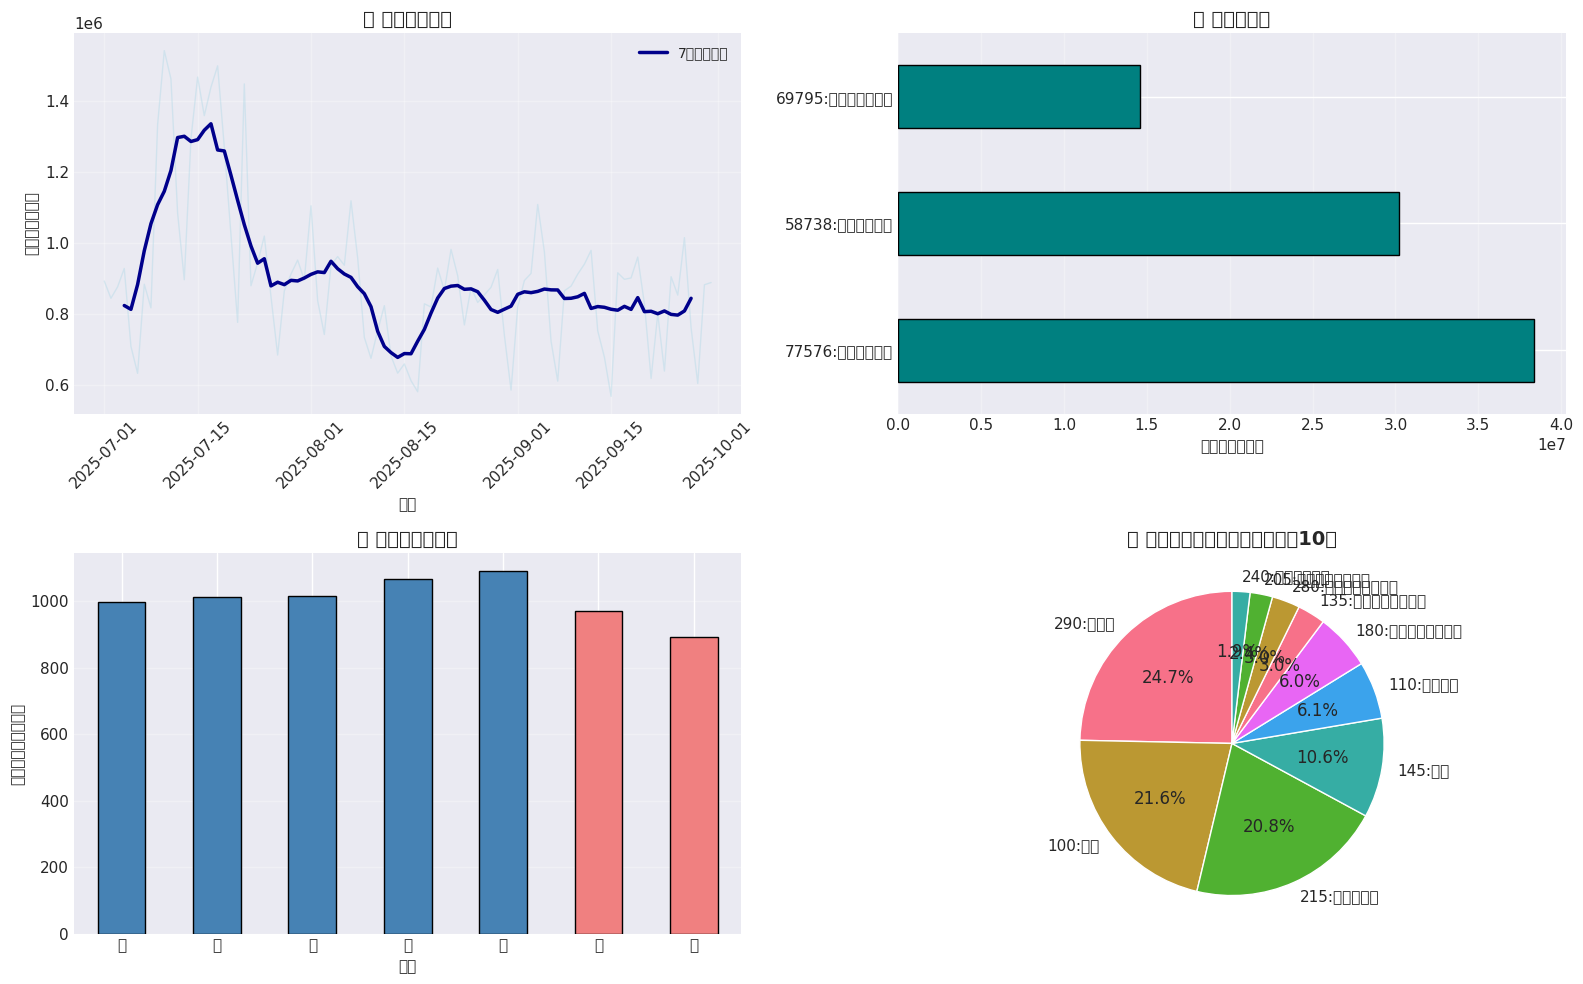

In [3]:
print("="*80)
print("📈 KPI サマリー")
print("="*80)

# 全期間の集計
total_sales = df['売上金額'].sum()
total_quantity = df['売上数量'].sum()
total_days = (df['日付'].max() - df['日付'].min()).days + 1
daily_avg = total_sales / total_days

# 最新週と前週の比較
latest_date = df['日付'].max()
week_ago = latest_date - timedelta(days=7)
two_weeks_ago = latest_date - timedelta(days=14)

latest_week_sales = df[df['日付'] > week_ago]['売上金額'].sum()
previous_week_sales = df[(df['日付'] > two_weeks_ago) & (df['日付'] <= week_ago)]['売上金額'].sum()

week_change = ((latest_week_sales / previous_week_sales - 1) * 100) if previous_week_sales > 0 else 0

print(f"\n【全期間サマリー（{total_days}日間）】")
print(f"  💰 総売上: ¥{total_sales:,.0f}")
print(f"  📦 総販売数: {total_quantity:,.0f}個")
print(f"  📊 1日平均売上: ¥{daily_avg:,.0f}")
print(f"  💵 平均単価: ¥{total_sales/total_quantity:,.0f}/個")

print(f"\n【最新週 vs 前週】")
print(f"  最新週売上: ¥{latest_week_sales:,.0f}")
print(f"  前週売上: ¥{previous_week_sales:,.0f}")
print(f"  変化率: {week_change:+.1f}%")

if week_change > 0:
    print(f"\n  ✅ 前週比で売上が{week_change:.1f}%増加（好調）")
elif week_change < 0:
    print(f"\n  ⚠️ 前週比で売上が{abs(week_change):.1f}%減少（要注意）")
else:
    print(f"\n  → 前週と同水準")

# KPIの可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 日次売上推移
daily_sales = df.groupby('日付')['売上金額'].sum()
daily_sales_ma7 = daily_sales.rolling(window=7, center=True).mean()

axes[0, 0].plot(daily_sales.index, daily_sales.values, alpha=0.4, color='lightblue', linewidth=1)
axes[0, 0].plot(daily_sales_ma7.index, daily_sales_ma7.values, color='darkblue', linewidth=2.5, label='7日移動平均')
axes[0, 0].set_title('📈 日次売上推移', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('日付', fontsize=11)
axes[0, 0].set_ylabel('売上金額（円）', fontsize=11)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 店舗別売上
store_sales = df.groupby('店舗')['売上金額'].sum().sort_values(ascending=False)
store_sales.plot(kind='barh', ax=axes[0, 1], color='teal', edgecolor='black')
axes[0, 1].set_title('🏪 店舗別売上', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('売上金額（円）', fontsize=11)
axes[0, 1].set_ylabel('')
axes[0, 1].grid(axis='x', alpha=0.3)

# 曜日別売上
weekday_map = {0: '月', 1: '火', 2: '水', 3: '木', 4: '金', 5: '土', 6: '日'}
df['曜日名'] = df['日付'].dt.dayofweek.map(weekday_map)
weekday_order = ['月', '火', '水', '木', '金', '土', '日']
weekday_sales = df.groupby('曜日名')['売上金額'].mean().reindex(weekday_order)

colors = ['lightcoral' if day in ['土', '日'] else 'steelblue' for day in weekday_order]
weekday_sales.plot(kind='bar', ax=axes[1, 0], color=colors, edgecolor='black')
axes[1, 0].set_title('📅 曜日別平均売上', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('曜日', fontsize=11)
axes[1, 0].set_ylabel('平均売上金額（円）', fontsize=11)
axes[1, 0].set_xticklabels(weekday_order, rotation=0)
axes[1, 0].grid(axis='y', alpha=0.3)

# カテゴリ別売上構成比（上位10）
category_sales = df.groupby('フェイスくくり大分類')['売上金額'].sum().sort_values(ascending=False).head(10)
category_sales.plot(kind='pie', ax=axes[1, 1], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('📦 カテゴリ別売上構成比（上位10）', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()

## 🎯 4. ABC分析サマリー

### 重点管理商品の状況

In [4]:
if product_abc is not None:
    print("="*80)
    print("🎯 ABC分析サマリー")
    print("="*80)
    
    # ABCランク別の商品数
    abc_counts = product_abc['ABCランク'].value_counts()
    
    print("\n【ABCランク別商品数】")
    for rank in ['A', 'B', 'C']:
        count = abc_counts.get(rank, 0)
        pct = count / len(product_abc) * 100
        print(f"  {rank}ランク: {count}商品 ({pct:.1f}%)")
    
    # A商品の詳細
    a_products = product_abc[product_abc['ABCランク'] == 'A'].sort_values('売上金額', ascending=False)
    
    print(f"\n【A商品TOP10（重点管理商品）】")
    print(a_products.head(10)[['商品名', '売上金額', '売上数量', '構成比', 'ABCランク']].to_string(index=False))
    
    print("\n💡 これらのA商品は絶対に欠品させないこと！")
    
    # C商品の詳細
    c_products = product_abc[product_abc['ABCランク'] == 'C'].sort_values('売上金額', ascending=True)
    
    print(f"\n【C商品（在庫削減候補）】")
    print(f"  C商品数: {len(c_products)}商品")
    print(f"  C商品売上合計: ¥{c_products['売上金額'].sum():,.0f}")
    print(f"  全体に占める割合: {c_products['売上金額'].sum() / product_abc['売上金額'].sum() * 100:.1f}%")
    
    print("\n💡 C商品は在庫を最小限にし、売場をA/B商品に振り分ける")
    
else:
    print("⚠️ ABC分析結果が読み込まれていません")
    print("  Stage 2のノートブックを実行してください")

🎯 ABC分析サマリー

【ABCランク別商品数】
  Aランク: 376商品 (19.8%)
  Bランク: 462商品 (24.4%)
  Cランク: 1059商品 (55.8%)

【A商品TOP10（重点管理商品）】
                  商品名     売上金額  売上数量  構成比 ABCランク
        テリアメンソール 1,960,992.00  3,714.00    2.36         A
    い・ろ・は・す５４０ 1,190,974.00 10,093.00    1.43         A
     ◎ジャスミン茶６００ 1,180,190.00 10,729.00    1.42         A
          直巻　焼しゃけ 1,021,944.00  6,468.00    1.23         A
             ◎緑茶６００ 1,019,700.00  9,270.00    1.23         A
          テリアＯパール   968,880.00  1,835.00    1.17         A
直巻　和風ツナマヨネーズ   947,640.00  6,360.00    1.14         A
手巻シーチキンマヨネーズ   880,770.00  5,338.00    1.06         A
        鮭はらみおむすび   870,492.00  3,374.00    1.05         A
    ３種のミックスサンド   823,672.00  2,764.00    0.99         A

💡 これらのA商品は絶対に欠品させないこと！

【C商品（在庫削減候補）】
  C商品数: 1059商品
  C商品売上合計: ¥4,269,644
  全体に占める割合: 5.1%

💡 C商品は在庫を最小限にし、売場をA/B商品に振り分ける


## 📋 5. 発注推奨リスト

### 今日発注すべき主要商品

In [5]:
if order_params is not None:
    print("="*80)
    print("📋 発注推奨リスト")
    print("="*80)
    
    # 発注が必要な商品（平均売上が高い順に上位30）
    order_list = order_params.sort_values('平均', ascending=False).head(30).copy()
    
    # 今日の曜日を取得
    today_weekday = datetime.now().weekday()
    weekday_map = {0: '月', 1: '火', 2: '水', 3: '木', 4: '金', 5: '土', 6: '日'}
    today_name = weekday_map[today_weekday]
    
    print(f"\n本日: {datetime.now().strftime('%Y-%m-%d')} ({today_name}曜日)")
    print(f"\n【主要商品発注推奨量（上位20商品）】")
    print(order_list.head(20)[['商品名', '平均', '安全在庫', '発注点', '推奨発注量_週間', '需要パターン']].to_string(index=False))
    
    print("\n" + "-"*80)
    print("【発注の実務】")
    print("  1. 現在の在庫数を確認")
    print("  2. 在庫が『発注点』を下回っている商品を発注")
    print("  3. 発注量は『推奨発注量_週間』を基準に、曜日で調整")
    print("  4. 『安全在庫』は常に確保しておく")
    
    # 需要変動が大きい商品（発注注意）
    high_variance = order_params[
        (order_params['需要パターン'] == '変動大') &
        (order_params['平均'] >= 5)
    ].sort_values('変動係数_CV', ascending=False).head(10)
    
    if len(high_variance) > 0:
        print("\n" + "-"*80)
        print("⚠️ 【発注注意商品（需要変動が大きい）】")
        print(high_variance[['商品名', '平均', '標準偏差', '変動係数_CV', '需要パターン']].to_string(index=False))
        print("\n💡 これらの商品は天気・イベントの影響を受けやすいため、慎重に発注する")
    
else:
    print("⚠️ 発注パラメータが読み込まれていません")
    print("  Stage 3のノートブックを実行してください")

📋 発注推奨リスト

本日: 2025-10-08 (水曜日)

【主要商品発注推奨量（上位20商品）】
                  商品名   平均  安全在庫  発注点  推奨発注量_週間 需要パターン
    い・ろ・は・す５４０ 168.22    131.00  299.00         1,178.00         通常
  ポケカ拡張インフェルノ 156.50    385.00  542.00         1,096.00       変動大
                  レジ袋 138.97     38.00  177.00           973.00         安定
サントリー天然水　５５０ 134.70     65.00  200.00           943.00         安定
     ◎ジャスミン茶６００ 116.62     53.00  170.00           816.00         安定
             ◎緑茶６００ 100.76     57.00  158.00           705.00         通常
 ◎天然水新潟県津南６００  78.55     38.00  117.00           550.00         通常
          直巻　焼しゃけ  70.30     43.00  113.00           492.00         通常
直巻　和風ツナマヨネーズ  69.13     45.00  114.00           484.00         通常
      健康ミネラルむぎ茶  59.59     81.00  141.00           417.00       変動大
手巻シーチキンマヨネーズ  58.02     29.00   87.00           406.00         通常
  ポケカ拡張メガブレイブ  57.42     87.00  144.00           402.00       変動大
  レジ袋１２号バイオマス  57.05     18.00   75.00           399.00         安定
午後フル

## 🌤️ 6. 外部要因チェック

### 天気・イベントの影響確認

In [6]:
print("="*80)
print("🌤️ 外部要因チェック")
print("="*80)

# 直近データから外部要因を確認
latest_data = df[df['日付'] == df['日付'].max()].iloc[0]

print(f"\n【最新日のデータ: {latest_data['日付'].strftime('%Y-%m-%d')}】")

# 気温情報
if '最高気温' in df.columns:
    print(f"\n🌡️ 気温情報")
    print(f"  最高気温: {latest_data['最高気温']:.1f}℃")
    if '最低気温' in df.columns:
        print(f"  最低気温: {latest_data['最低気温']:.1f}℃")
    if '平均気温' in df.columns:
        print(f"  平均気温: {latest_data['平均気温']:.1f}℃")

# 天気情報
if '降雨フラグ' in df.columns:
    weather = '雨' if latest_data['降雨フラグ'] == 1 else '晴れ'
    print(f"\n☀️ 天気: {weather}")

# カレンダー情報
print(f"\n📅 カレンダー情報")
if '休日フラグ' in df.columns:
    holiday_status = '休日' if latest_data['休日フラグ'] == 1 else '平日'
    print(f"  {holiday_status}")

if '連休フラグ' in df.columns and latest_data['連休フラグ'] == 1:
    print(f"  ✓ 連休期間中")

if '給料日前後フラグ' in df.columns and latest_data['給料日前後フラグ'] == 1:
    print(f"  ✓ 給料日前後")

if '学校休み期間フラグ' in df.columns and latest_data['学校休み期間フラグ'] == 1:
    print(f"  ✓ 学校休み期間")

print("\n" + "-"*80)
print("💡 発注への影響")

# 気温に基づく発注アドバイス
if '最高気温' in df.columns:
    temp = latest_data['最高気温']
    if temp >= 30:
        print("  🔥 猛暑日 → 冷たい飲料・アイス類の発注を増やす")
    elif temp >= 25:
        print("  ☀️ 夏日 → 冷たい商品の需要が高まる")
    elif temp <= 10:
        print("  ❄️ 寒い日 → 温かい飲料・おでん等の発注を増やす")

# 天気に基づく発注アドバイス
if '降雨フラグ' in df.columns:
    if latest_data['降雨フラグ'] == 1:
        print("  🌧️ 雨 → 客数減少傾向、発注は抑えめに（弁当・傘は増やす）")
    else:
        print("  ☀️ 晴れ → 通常の発注")

# カレンダーに基づく発注アドバイス
if '休日フラグ' in df.columns and latest_data['休日フラグ'] == 1:
    print("  🎌 休日 → 平日より発注量を調整（休日パターン参照）")

if '給料日前後フラグ' in df.columns and latest_data['給料日前後フラグ'] == 1:
    print("  💰 給料日前後 → 売上増加傾向、発注を増やす")

🌤️ 外部要因チェック

【最新日のデータ: 2025-09-30】

🌡️ 気温情報
  最高気温: 27.4℃
  最低気温: 20.6℃
  平均気温: 24.0℃

☀️ 天気: 雨

📅 カレンダー情報
  平日

--------------------------------------------------------------------------------
💡 発注への影響
  ☀️ 夏日 → 冷たい商品の需要が高まる
  🌧️ 雨 → 客数減少傾向、発注は抑えめに（弁当・傘は増やす）


## ✅ 7. 今日のアクションリスト

### 優先的に実施すべきタスク

In [7]:
print("="*80)
print("✅ 今日のアクションリスト")
print("="*80)

action_list = []

# 1. 売上トレンドチェック
if week_change < -5:
    action_list.append("🔴【緊急】売上が前週比で5%以上減少 → 原因分析と対策が必要")
elif week_change < 0:
    action_list.append("🟡【注意】売上が前週比で減少 → トレンドを注視")

# 2. A商品の在庫確認
if product_abc is not None:
    a_count = len(product_abc[product_abc['ABCランク'] == 'A'])
    action_list.append(f"✅ A商品{a_count}個の在庫を確認し、発注点を下回っていないかチェック")

# 3. C商品の在庫削減
if product_abc is not None:
    c_count = len(product_abc[product_abc['ABCランク'] == 'C'])
    action_list.append(f"📦 C商品{c_count}個の在庫状況を確認し、過剰在庫があれば発注停止")

# 4. 天気に応じた発注調整
if '降雨フラグ' in df.columns and latest_data['降雨フラグ'] == 1:
    action_list.append("🌧️ 雨予報 → 発注量を抑えめに（傘・弁当は例外）")

# 5. イベント対応
if '休日フラグ' in df.columns and latest_data['休日フラグ'] == 1:
    action_list.append("🎌 休日 → 平日と異なる発注パターンを適用")

if '給料日前後フラグ' in df.columns and latest_data['給料日前後フラグ'] == 1:
    action_list.append("💰 給料日前後 → 発注量を増やす")

# 6. 定常タスク
action_list.append("📊 Stage 1〜4のノートブックを定期的に実行し、分析結果を更新")
action_list.append("🤖 PyCaretモデルを使った需要予測を確認（Stage 5）")

# アクションリストを表示
print("\n【優先度順タスクリスト】")
for i, action in enumerate(action_list, 1):
    print(f"\n{i}. {action}")

print("\n" + "="*80)

✅ 今日のアクションリスト

【優先度順タスクリスト】

1. ✅ A商品376個の在庫を確認し、発注点を下回っていないかチェック

2. 📦 C商品1059個の在庫状況を確認し、過剰在庫があれば発注停止

3. 🌧️ 雨予報 → 発注量を抑えめに（傘・弁当は例外）

4. 📊 Stage 1〜4のノートブックを定期的に実行し、分析結果を更新

5. 🤖 PyCaretモデルを使った需要予測を確認（Stage 5）



## 📝 8. レポート保存

### 週次・月次レポートとして保存

In [8]:
# レポートディレクトリ
report_dir = Path('output/dashboard_reports')
report_dir.mkdir(parents=True, exist_ok=True)

# 日付付きのレポート名
report_date = datetime.now().strftime('%Y%m%d')

# KPIサマリーを保存
kpi_summary = pd.DataFrame({
    '指標': ['総売上', '1日平均売上', '総販売数', '平均単価', '最新週売上', '前週売上', '週次変化率'],
    '値': [
        f'¥{total_sales:,.0f}',
        f'¥{daily_avg:,.0f}',
        f'{total_quantity:,.0f}個',
        f'¥{total_sales/total_quantity:,.0f}',
        f'¥{latest_week_sales:,.0f}',
        f'¥{previous_week_sales:,.0f}',
        f'{week_change:+.1f}%'
    ]
})

kpi_summary.to_csv(report_dir / f'KPIサマリー_{report_date}.csv', index=False, encoding='utf-8-sig')

# 店舗別売上を保存
store_sales_df = store_sales.reset_index()
store_sales_df.columns = ['店舗', '売上金額']
store_sales_df.to_csv(report_dir / f'店舗別売上_{report_date}.csv', index=False, encoding='utf-8-sig')

# 曜日別売上を保存
weekday_sales_df = weekday_sales.reset_index()
weekday_sales_df.columns = ['曜日', '平均売上金額']
weekday_sales_df.to_csv(report_dir / f'曜日別売上_{report_date}.csv', index=False, encoding='utf-8-sig')

print("="*80)
print("📝 レポート保存")
print("="*80)
print(f"\n✅ レポートを保存しました: {report_dir}/")
print("\n📋 保存ファイル:")
print(f"  - KPIサマリー_{report_date}.csv")
print(f"  - 店舗別売上_{report_date}.csv")
print(f"  - 曜日別売上_{report_date}.csv")

print("\n💡 これらのファイルを本部への報告資料として活用できます")

📝 レポート保存

✅ レポートを保存しました: output/dashboard_reports/

📋 保存ファイル:
  - KPIサマリー_20251008.csv
  - 店舗別売上_20251008.csv
  - 曜日別売上_20251008.csv

💡 これらのファイルを本部への報告資料として活用できます


## 💡 9. まとめ

### このダッシュボードの使い方

#### 日次運用フロー
```
【毎朝の確認】
1. このノートブックを実行
2. KPIサマリーで全体状況を把握
3. 外部要因チェックで今日の天気・イベントを確認
4. アクションリストに従って業務を実施

【発注前】
5. 発注推奨リストを確認
6. 天気予報と照らし合わせて発注量を調整
7. A商品の欠品がないか最終チェック
```

#### 週次運用フロー
```
【週次会議】
1. 前週比の変化を確認
2. ABC分析で商品構成を見直し
3. C商品の在庫削減を検討
4. 次週の発注計画を立案
```

#### 月次運用フロー
```
【月次報告】
1. 保存されたレポートを集計
2. トレンド分析（成長/減少）
3. 本部への報告資料作成
4. PyCaretモデルの再学習を検討
```

---

### Stage 1〜5の活用マップ

| Stage | 目的 | 実施頻度 | 業務への活用 |
|-------|------|----------|-------------|
| Stage 1 | 現状把握 | 週次 | 売上トレンド・店舗比較 |
| Stage 2 | ABC分析 | 月次 | 商品構成の見直し |
| Stage 3 | 発注最適化 | 日次 | 発注量の決定 |
| Stage 4 | 外部要因分析 | 週次 | 天気・イベント対応 |
| Stage 5 | 需要予測 | 日次 | AI予測による発注 |
| ダッシュボード | 統合管理 | 日次 | 意思決定支援 |

---

### データドリブン経営の実現

**このダッシュボードを使うことで:**
- ✅ 勘に頼らず、データで意思決定できる
- ✅ 欠品・廃棄を最小化し、利益率を向上できる
- ✅ 本部への報告が客観的なデータで行える
- ✅ 店舗運営の改善点が明確になる

**継続的な改善が重要:**
- 📊 週次でStage 1〜4のノートブックを実行
- 🤖 月次でPyCaretモデルを再学習
- 📈 データを蓄積し、予測精度を向上
- 💡 分析結果を実務に反映し、PDCAサイクルを回す

---

In [9]:
# 日本語フォント最終固定（Seaborn後でも有効）
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

# japanize_matplotlib を優先（同梱の IPAexGothic を使用）
chosen = None
try:
    import japanize_matplotlib  # noqa: F401
    chosen = "IPAexGothic"
except Exception:
    pass

# フォント候補
candidates = ["IPAexGothic","IPAPGothic","Noto Sans CJK JP","Noto Sans JP","Hiragino Sans","Hiragino Kaku Gothic ProN","Meiryo","MS Gothic"]
avail = {f.name: f.fname for f in font_manager.fontManager.ttflist}

if not chosen:
    for n in candidates:
        if n in avail or any(n.lower() in nm.lower() for nm in avail):
            chosen = n
            break

if chosen:
    rcParams.update({
        "font.family": "sans-serif",
        "font.sans-serif": [chosen, "DejaVu Sans"],
        "axes.unicode_minus": False,
    })
    try:
        import seaborn as sns
        sns.set(font=chosen, rc={"font.family":"sans-serif","font.sans-serif":[chosen, "DejaVu Sans"], "axes.unicode_minus": False})
    except Exception:
        pass
    print("日本語フォント固定:", chosen)
else:
    print("日本語フォント未検出。'Noto Sans CJK JP' 等のインストールが必要です。")

日本語フォント固定: IPAexGothic
